In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

sys.path.insert(0, '/Users/handanbinaerin/Library/Mobile Documents/com~apple~CloudDocs/music_edu')
from treat_song import GetSongInfo

file_path2 = 'processed_performance_data 2.json'
song_info_path = 'learning_points.json'

with open(file_path2, 'r') as file:
    data = json.load(file)

with open(song_info_path, 'r') as file:
    song_info = json.load(file)

In [42]:
sample = data[13] 

# 객체 생성
song_analyzer = GetSongInfo(sample, song_info)

# __call__ 메서드 사용 (객체를 함수처럼 호출)
result = song_analyzer(top_n=3)
result
# result['overall_summary']['pitch_accuracy_percent']

{'song_info': {'song_id': 'minuet', 'song_type': 'recorder'},
 'overall_summary': {'pitch_accuracy_percent': 0.0,
  'frequent_wrong_notes': [{'note': '파'}, {'note': '라'}, {'note': '솔'}]},
 'critical_measures': {'44': {'pitch_level': '중간 음역대',
   'pitch_variability': '음정 변화가 많음',
   'pitch_direction': '상행',
   'note_density': '빠른 패시지',
   'pitch_error': '매우 높음 (+13.1)',
   'frequent_wrong_syllables': ['도', '레', '미']},
  '0': {'pitch_level': '고음역대',
   'pitch_variability': '음정 변화가 많음',
   'pitch_direction': '복합적 이동',
   'note_density': '보통',
   'pitch_error': '매우 높음 (+12.1)',
   'frequent_wrong_syllables': ['높은 도', '파', '솔']},
  '42': {'pitch_level': '고음역대',
   'pitch_variability': '음정 변화 적음',
   'pitch_direction': '하행',
   'note_density': '보통',
   'pitch_error': '매우 높음 (+13.0)',
   'frequent_wrong_syllables': ['높은 도', '라#', '라']},
  '36': {'pitch_level': '고음역대',
   'pitch_variability': '음정 변화가 많음',
   'pitch_direction': '상행',
   'note_density': '빠른 패시지',
   'pitch_error': '매우 높음 (+12.3)

In [44]:
all_results = {}
for d in data:
  song_analyzer = GetSongInfo(sample, song_info)
  result = song_analyzer(top_n=3)
  all_results[d['recording_id']] = result


korean_vocal:
  샘플 수: 145개
  평균: 30.17%
  중간값: 14.06%
  표준편차: 35.58%
  범위: 0.00% ~ 100.00%

recorder:
  샘플 수: 121개
  평균: 16.44%
  중간값: 0.00%
  표준편차: 36.14%
  범위: 0.00% ~ 100.00%

western_vocal:
  샘플 수: 57개
  평균: 65.88%
  중간값: 82.65%
  표준편차: 33.28%
  범위: 0.00% ~ 100.00%


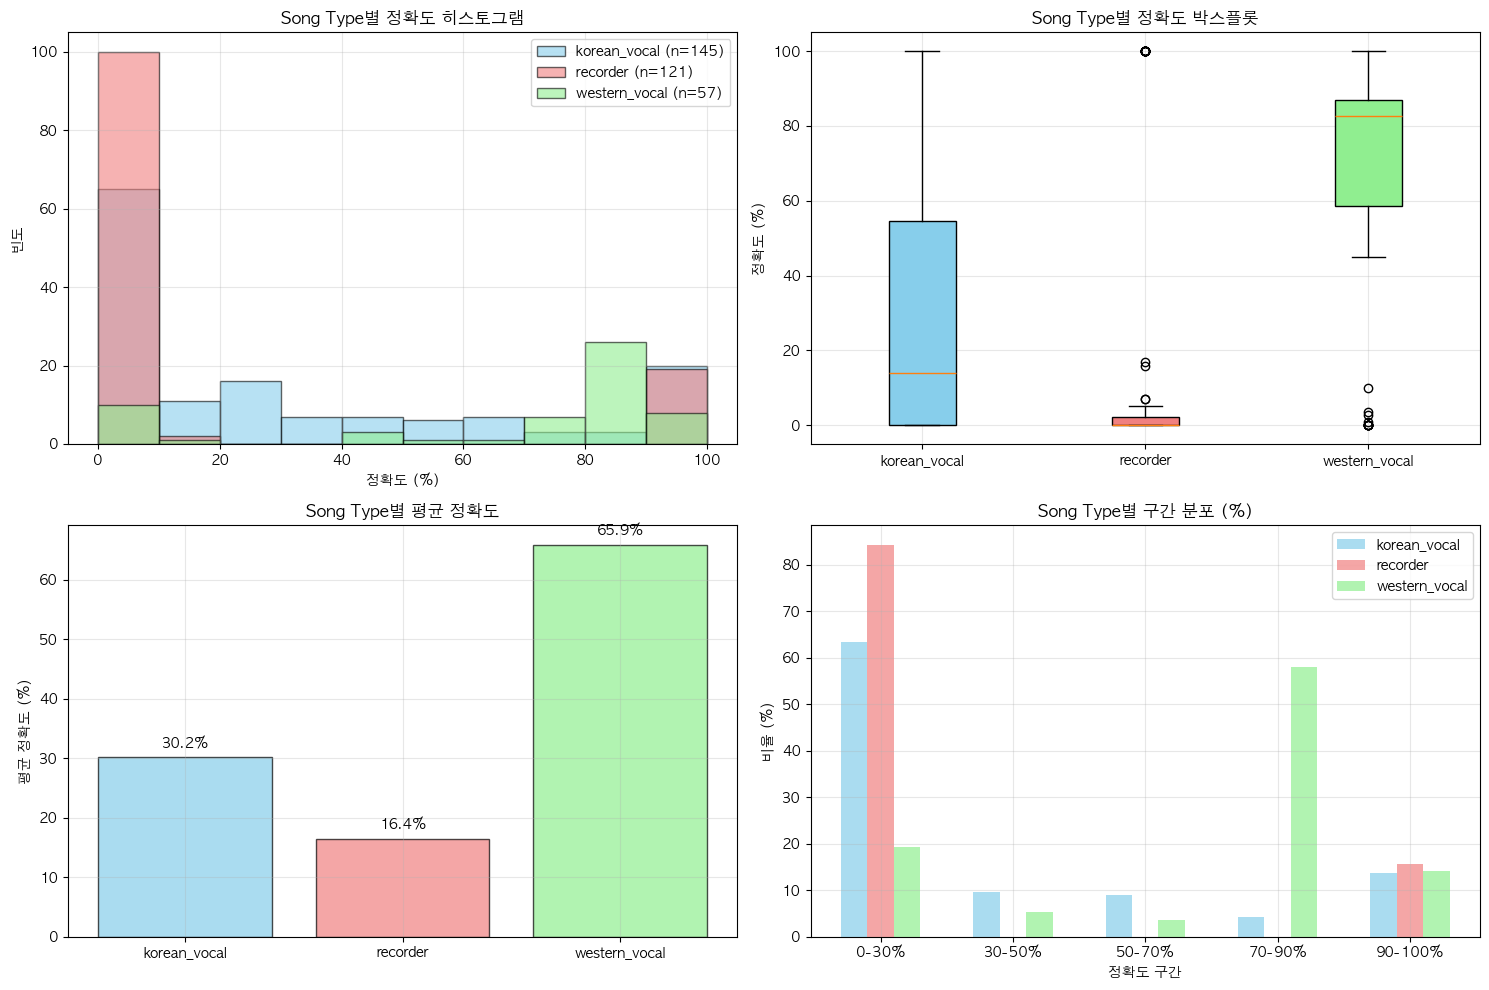

In [52]:
from treat_song import visualize_acc_by_type

threshold = 1.0
acc_by_type = defaultdict(list)
for sample in data:
    song_analyzer = GetSongInfo(sample, song_info)
    d = song_analyzer(top_n=1, threshold=threshold)
    song_type = song_info[sample['song_id']]['song_type']
    acc = d['overall_summary']['pitch_accuracy_percent']
    acc_by_type[song_type].append(acc)
    
visualize_acc_by_type(acc_by_type)


korean_vocal:
  샘플 수: 145개
  평균: 22.59%
  중간값: 6.45%
  표준편차: 33.01%
  범위: 0.00% ~ 100.00%

recorder:
  샘플 수: 121개
  평균: 16.14%
  중간값: 0.00%
  표준편차: 36.23%
  범위: 0.00% ~ 100.00%

western_vocal:
  샘플 수: 57개
  평균: 52.11%
  중간값: 62.89%
  표준편차: 28.83%
  범위: 0.00% ~ 100.00%


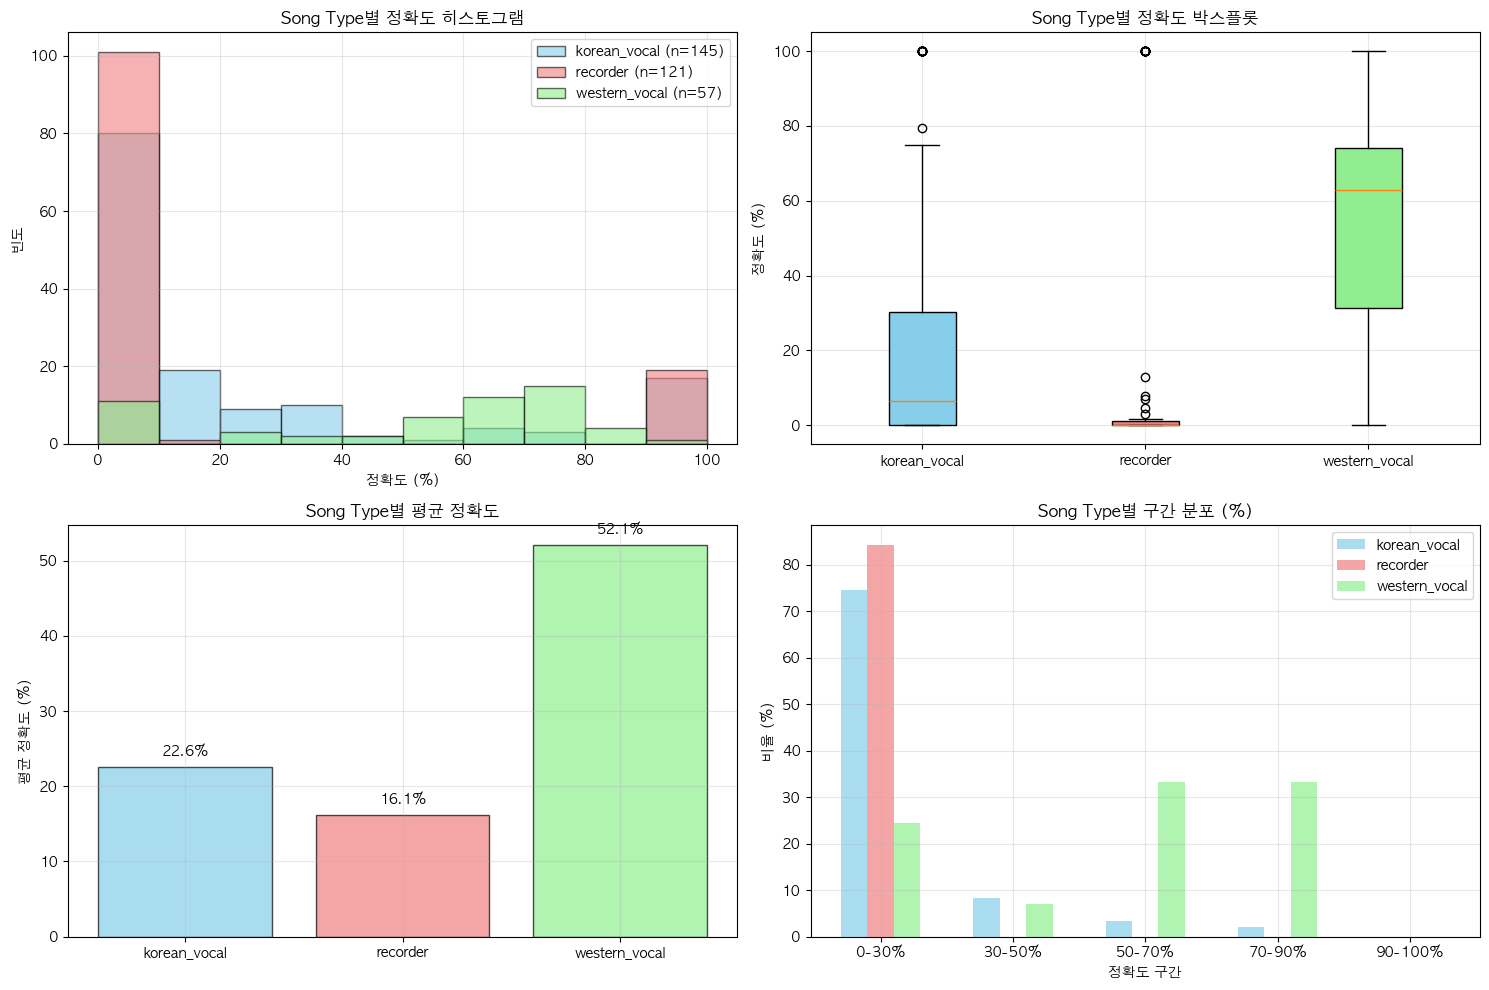

{'overall_summary': {'pitch_accuracy_percent': 34.23,
                     'frequent_wrong_notes': [{'note': '미'},
                                              {'note': '도'},
                                              {'note': '솔'}]},
 'critical_measures': {'16': {'pitch_level': '중간 음역대',
                              'pitch_variability': '음정 변화 적음',
                              'pitch_direction': '복합적 이동',
                              'note_density': '빠른 패시지',
                              'pitch_error': '매우 높음 (+1.9)',
                              'frequent_wrong_syllables': ['내(미)',
                                                           '사(솔)',
                                                           '-(미)'],
                              'lyrics': ['내', '사', '-', '랑', '-', '-', '아'],
                              'learning_point': '7~8마디처럼 숨 쉬는 위치가 다른 구간이므로, 숨 '
                                                '쉬는 타이밍을 정확히 파악하고 음악 흐름이 끊기지 '
                             